## Baseline model for bus 203

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [2]:
train = pickle.load(open('benchmark_train.pkl', 'rb'))
test = pickle.load(open('benchmark_test.pkl', 'rb'))

In [3]:
#bus_line_file = '../bus203_all.csv'

In [4]:
# convert timestamp columns to pandas datetimes
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'] = train['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'] = test['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

In [5]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'
      .format(len(train.index) / (len(train.index) + len(test.index))))
print('test data rows comprise {:.4f}% of the total data'
      .format(len(test.index) / (len(train.index) + len(test.index))))

train data rows comprise 0.8000% of the total data
test data rows comprise 0.2000% of the total data


### Calculate the median travel times for each segment in the train data

In [6]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16 04:48:40+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.0,-1.0,NaN,1,1


Now lets calculate the median travel time to the station when looking at the remaining 80%, 60%, 40%, and 20% of the segment. These numbers are then used to make predictions on the unseen test data. 

We can group by `journey_number` and `segment_number`, and loop over these groups, using 5 different slices for the journey_number-segment_number unique group. Each group is equal to the data points of a single bus driving a single segment once.

In [7]:
def interval_time(x):
    """
    Get the travel time within the current segment slice/interval
    """
    timedelta = x['timestamp'].max() - x['timestamp'].min()
    return timedelta.seconds

In [8]:
data = []
for name, group in train.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    interval_data = []
    for idx in indexes:
        interval_data.append(interval_time(group[idx:]))
    data.append([name[1]] + interval_data)

In [9]:
pred_df = pd.DataFrame(columns=['sn', '20_p', '40_p', '60_p', '80_p'], data=data)

In [10]:
pred_df = pred_df.groupby('sn').median().reset_index()

In [11]:
pred_df # our predictions for arrival time at intervals 20%..80% traveled on segment

,sn,20_p,40_p,60_p,80_p
0,1,152,113,75,38
1,2,45,35,23,11
2,3,51,40,26,13
3,4,35,26,18,8
4,5,43,32,21,10
5,6,49,38,25,12
6,7,80,61,41,20
7,8,37,29,19,9
8,9,128,96,64,31
9,10,59,45,30,15


In [12]:
pickle.dump(pred_df, open('prediction_df_203.p', 'wb'))

The dataframe above holds our median segment durations, which will be used to make predictions on the test set.

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through all segments in the test data for each journey and subtract the average segment time from the actual segment time. We can then calculate how big the error was, expressed as a percentage of the actual segment time. 

In [13]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    # calculate our errors for each slice of the segment
    for idx, pred in zip(indexes, pred_df.columns[1:]):
        # get travel time to station in the slice of this segment in the test data
        seg_time = interval_time(group[idx:])
        # get error between prediction and actual travel time
        error_s = seg_time - pred_df[pred_df.sn == name[1]][pred].iloc[0]
        # get error as a percentage of the ground truth segment travel time
        error_p = error_s / seg_time * 100
        # get the absolute values of the errors in seconds and as a percentage
        abs_error_s = abs(error_s)
        abs_error_p = abs(error_p)
        data.append([name[1], pred, error_s, error_p, abs_error_s, abs_error_p])

In [14]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [15]:
error_df.head(5)

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,20_p,17,10.059172,17,10.059172
1,1,40_p,13,10.317460,13,10.317460
2,1,60_p,8,9.638554,8,9.638554
3,1,80_p,4,9.523810,4,9.523810
4,2,20_p,3,6.250000,3,6.250000


# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The values of the column "slice", such as `20_p`, `40_p`, means predictions after travelling 20%, 40% etc.

In [16]:
error_df.groupby('slice').mean()

,segment,error_s,error_p,abs_error_s,abs_error_p
slice,,,,,
20_p,6.0,1.003662,-7.049464,11.726894,21.706085
40_p,6.0,0.369823,-8.567392,8.879419,22.480316
60_p,6.0,0.279293,-8.957323,6.074747,23.575517
80_p,6.0,0.113384,-10.388638,3.070707,25.404522


In [17]:
error_df.groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,2.827778,-3.044704,13.677083,15.622008
2,0.164583,-8.312157,5.447222,22.939259
3,-0.784375,-9.844672,5.415625,20.636173
4,-1.809028,-25.613165,6.295833,41.971369
5,2.348958,4.015480,5.010764,15.917261
6,-0.762500,-9.132528,5.915972,22.101625
7,1.815278,-0.310110,7.300000,13.486305
8,-2.098958,-26.259310,6.501736,40.160897
9,2.666319,0.796810,10.067708,11.587855


In [18]:
error_df.groupby(['segment', 'slice']).mean()

error_s    error_p  abs_error_s  abs_error_p
segment slice                                               
1       20_p   4.673611  -2.895406    22.004167    15.669780
        40_p   3.780556  -2.523647    16.430556    15.530733
        60_p   2.027778  -3.047050    10.869444    15.496839
        80_p   0.829167  -3.712713     5.404167    15.790679
2       20_p   0.737500  -6.338805     8.645833    21.519330
        40_p  -0.502778  -9.756670     6.313889    21.982722
        60_p   0.223611  -8.150538     4.506944    23.215271
        80_p   0.200000  -9.002613     2.322222    25.039715
3       20_p  -0.490278  -6.919484     8.506944    19.088607
        40_p  -1.531944 -10.350550     6.379167    19.895319
        60_p  -0.436111  -8.552182     4.472222    20.590199
        80_p  -0.679167 -13.556471     2.304167    22.970565
4       20_p  -2.897222 -23.010567     9.733333    37.797636
        40_p  -1.980556 -22.841017     7.436111    38.833798
        60_p  -1.918056 -29.551922     5.329167    44.004250
        80_p  -0.440278 -27.049151     2.684722    47.249790
5       20_p   3.387500   3.411282     7.651389    14.920585
        40_p   2.951389   4.104348     6.159722    15.755304
        60_p   2.011111   4.210440     4.130556    16.009599
        80_p   1.045833   4.335849     2.101389    16.983556
6       20_p  -0.765278  -7.063579     8.993056    20.016889
        40_p  -1.280556  -9.662861     7.202778    21.883286
        60_p  -0.718056  -9.569945     4.929167    22.506046
        80_p  -0.286111 -10.233726     2.538889    24.000281
7       20_p   3.461111   0.637642    11.825000    13.409248
        40_p   2.079167   0.018476     8.465278    12.794671
        60_p   1.151389  -0.785942     5.909722    13.552598
        80_p   0.569444  -1.110615     3.000000    14.188701
8       20_p  -2.661111 -21.244177    10.036111    35.684824
        40_p  -3.111111 -26.918887     7.786111    38.816019
        60_p  -1.784722 -26.830980     5.440278    40.960740
        80_p  -0.838889 -30.043195     2.744444    45.182003
9       20_p   4.095833   0.537596    15.965278    11.422083
        40_p   3.236111   0.655817    12.136111    11.566287
        60_p   1.886111   0.200712     8.125000    11.696380
        80_p   1.447222   1.793112     4.044444    11.666672
10      20_p   0.931944  -5.913984    12.193056    22.068247
        40_p   0.531944  -6.422141     9.137500    22.174180
        60_p   0.208333  -7.368967     6.233333    23.090303
        80_p  -0.350000 -11.581604     3.188889    25.469239
11      20_p   0.566667  -8.744624    13.441667    27.169708
        40_p  -0.104167 -10.544179    10.226389    28.051160
        60_p   0.420833  -9.084178     6.876389    28.208466
        80_p  -0.250000 -14.113894     3.444444    30.908542

In [19]:
error_df.groupby(['slice', 'segment']).mean()

error_s    error_p  abs_error_s  abs_error_p
slice segment                                               
20_p  1        4.673611  -2.895406    22.004167    15.669780
      2        0.737500  -6.338805     8.645833    21.519330
      3       -0.490278  -6.919484     8.506944    19.088607
      4       -2.897222 -23.010567     9.733333    37.797636
      5        3.387500   3.411282     7.651389    14.920585
      6       -0.765278  -7.063579     8.993056    20.016889
      7        3.461111   0.637642    11.825000    13.409248
      8       -2.661111 -21.244177    10.036111    35.684824
      9        4.095833   0.537596    15.965278    11.422083
      10       0.931944  -5.913984    12.193056    22.068247
      11       0.566667  -8.744624    13.441667    27.169708
40_p  1        3.780556  -2.523647    16.430556    15.530733
      2       -0.502778  -9.756670     6.313889    21.982722
      3       -1.531944 -10.350550     6.379167    19.895319
      4       -1.980556 -22.841017     7.436111    38.833798
      5        2.951389   4.104348     6.159722    15.755304
      6       -1.280556  -9.662861     7.202778    21.883286
      7        2.079167   0.018476     8.465278    12.794671
      8       -3.111111 -26.918887     7.786111    38.816019
      9        3.236111   0.655817    12.136111    11.566287
      10       0.531944  -6.422141     9.137500    22.174180
      11      -0.104167 -10.544179    10.226389    28.051160
60_p  1        2.027778  -3.047050    10.869444    15.496839
      2        0.223611  -8.150538     4.506944    23.215271
      3       -0.436111  -8.552182     4.472222    20.590199
      4       -1.918056 -29.551922     5.329167    44.004250
      5        2.011111   4.210440     4.130556    16.009599
      6       -0.718056  -9.569945     4.929167    22.506046
      7        1.151389  -0.785942     5.909722    13.552598
      8       -1.784722 -26.830980     5.440278    40.960740
      9        1.886111   0.200712     8.125000    11.696380
      10       0.208333  -7.368967     6.233333    23.090303
      11       0.420833  -9.084178     6.876389    28.208466
80_p  1        0.829167  -3.712713     5.404167    15.790679
      2        0.200000  -9.002613     2.322222    25.039715
      3       -0.679167 -13.556471     2.304167    22.970565
      4       -0.440278 -27.049151     2.684722    47.249790
      5        1.045833   4.335849     2.101389    16.983556
      6       -0.286111 -10.233726     2.538889    24.000281
      7        0.569444  -1.110615     3.000000    14.188701
      8       -0.838889 -30.043195     2.744444    45.182003
      9        1.447222   1.793112     4.044444    11.666672
      10      -0.350000 -11.581604     3.188889    25.469239
      11      -0.250000 -14.113894     3.444444    30.908542

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


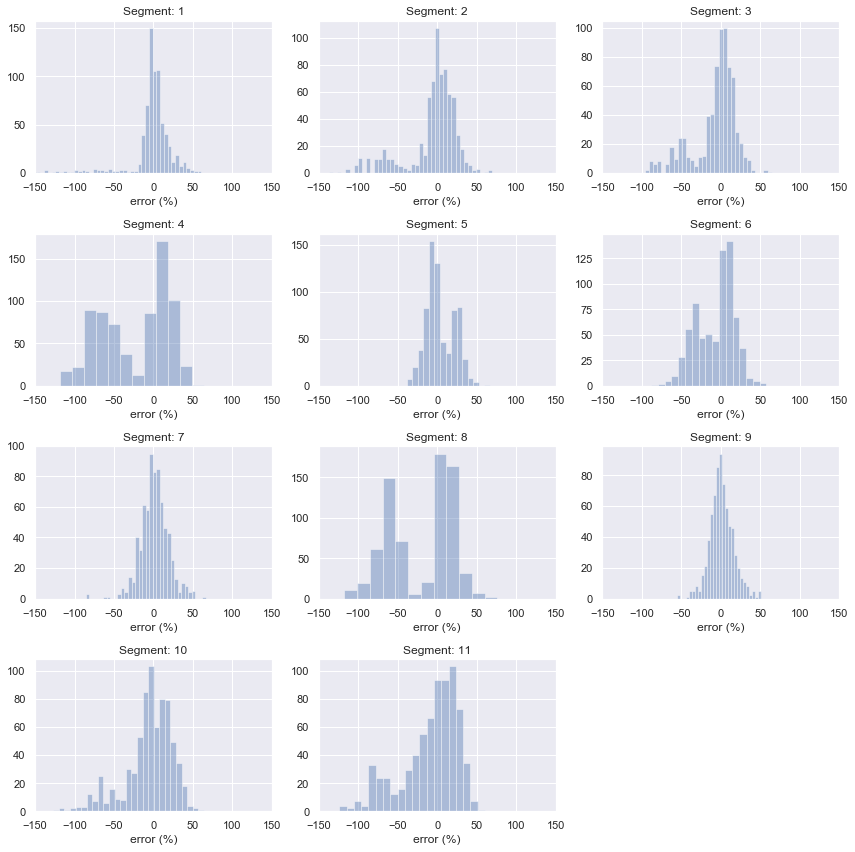

In [20]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


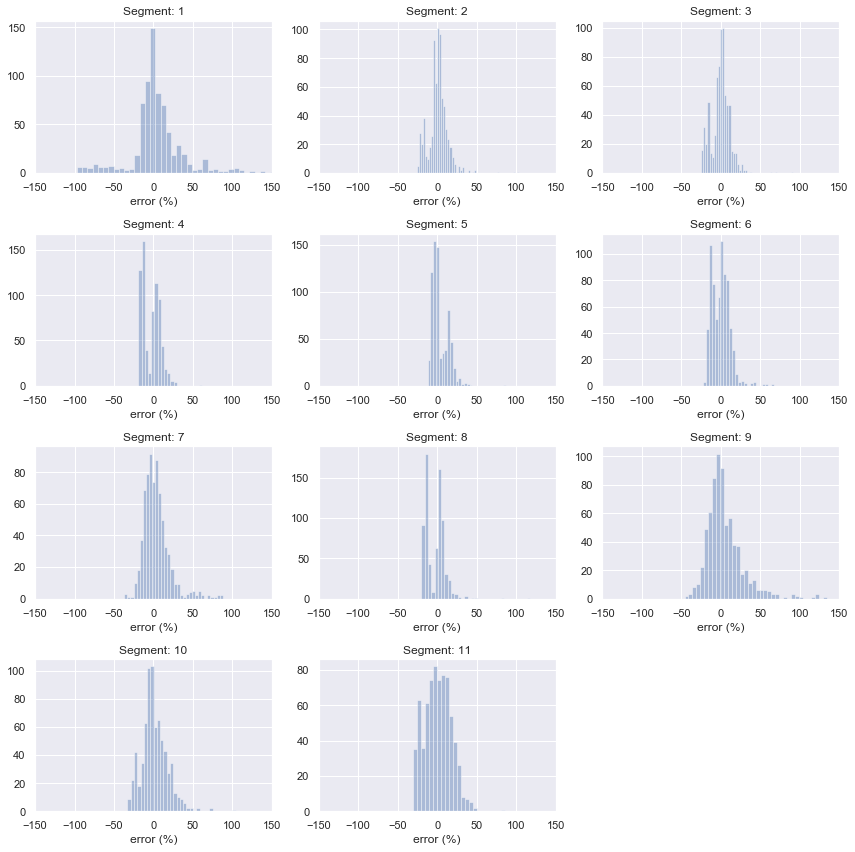

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()